In [1]:

!pip -q uninstall -y keras keras-nlp keras-core keras-cv || true

In [2]:
!pip -q install -U "tensorflow==2.18.0" "tf-keras==2.18.0" "tensorflow-text==2.18.1"
# (numpy 1.26.4 is fine with TF 2.18; no need to change)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.7 MB/s eta 0:00:00


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/processed-dl/balanced30k_processed_dl.csv


In [4]:
import pandas as pd
df = pd.read_csv('/kaggle/input/processed-dl/balanced30k_processed_dl.csv')
df.head()

,Title,review/score,review/text,categories,word_count,label,cleaned_text_dl
0,The Good Earth,2.0,The book The Good Earth is about the rise and ...,Juvenile Fiction,262,0,the book the good earth is about the rise and ...
1,Like Water for Chocolate,4.0,"Don't know why this book sticks in my mind, bu...",Fiction,55,2,"do not know why this book sticks in my mind , ..."
2,Shadowy Horses,4.0,By far the best of the latest crop of Romantic...,Fiction,247,2,by far the best of the latest crop of romantic...
3,"The Hobbitt, or there and back again; illustra...",5.0,"Classic tale, great illustrations. A known qua...",Fiction,23,2,"classic tale , great illustrations . a known q..."
4,Shamanspace,1.0,"For the past year, I had come across Steve Ayl...",Fiction,226,0,"for the past year , i had come across steve ay..."


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Dataset
X = df['cleaned_text_dl']
y = df['label']

2025-09-03 17:18:49.731014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756919929.964197      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756919930.032161      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Split into train (70%), val (20%), test (10%) with stratification to keep class balance
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_val)}')
print(f'Test size: {len(X_test)}')

Train size: 21000
Validation size: 6000
Test size: 3000


In [7]:
max_vocab_size = 20000
max_sequence_length = 250

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

print(f'Example tokenized sequence: {X_train_seq[0]}')
print(f'Example padded sequence shape: {X_train_pad.shape}')

Example tokenized sequence: [44, 23, 22, 25, 1326, 2525, 16, 21, 1, 313, 23, 53, 269, 124, 12, 11, 66, 38, 699, 1143, 8, 57, 708, 207, 9908, 221, 1, 55, 43, 1, 2, 1, 49, 382, 10, 130, 1143, 16, 21, 66, 8, 50, 5201, 3, 1, 83, 2, 334, 964, 3, 10957, 235, 4, 1, 313, 87, 99, 22, 5729, 28, 2, 719, 1, 4, 1996, 10, 1143, 16, 21, 66, 27, 15099, 1014, 3497, 4438, 1, 3, 995, 5869, 18, 6797, 254, 6, 1, 1, 313, 3, 13095, 429, 2, 1, 3, 1, 1, 4, 6613, 26, 1472, 184, 257, 6798, 18, 103, 33, 9, 15, 122, 10, 13096, 60, 780, 15, 2895, 231, 42, 160, 1996, 3, 1887, 17, 5, 129, 1382, 5, 67, 10, 73, 310, 4, 87, 7918, 15100, 10, 5, 563, 11621, 317, 3378, 11, 3809, 42, 2, 177, 2109, 3, 743, 10397, 4, 2, 7919, 6, 2, 5730, 528, 4, 2, 6993, 1629, 4665, 46, 3999, 53, 124, 143, 10, 11, 13, 12, 8, 1008, 2712, 25, 9, 824, 9, 8, 5, 751, 339, 3, 37, 1, 3416]
Example padded sequence shape: (21000, 250)


In [8]:
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-09-03 17:19:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-09-03 17:19:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-09-03 17:19:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [9]:
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [10]:
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(max_vocab_size, len(word_index) + 1)

# Build embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=num_words,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=max_sequence_length,
                           trainable=True))
model_bilstm.add(SpatialDropout1D(0.2)),
# Bidirectional LSTM, return_sequences=True to use all time steps
model_bilstm.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)))

model_bilstm.add(Dropout(0.35))

model_bilstm.add(GlobalMaxPooling1D())

model_bilstm.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))

model_bilstm.add(Dropout(0.35))

model_bilstm.add(Dense(3, activation='softmax'))

model_bilstm.compile(optimizer=Adam(5e-5, clipnorm=1.0), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])
model_bilstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-03 17:22:22.346529: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,    # stop if no improvement after 4 epochs
                           restore_best_weights=True,  # keep best model weights
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              min_lr=1e-6, 
                              verbose=1)
history = model_bilstm.fit(
    X_train_pad, 
    y_train, 
    epochs=50,           # Start with 10 epochs, adjust based on over/underfitting
    batch_size=32,       # Common batch size for moderate dataset size
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/50
657/657 - 288s - 438ms/step - accuracy: 0.3493 - loss: 1.1303 - val_accuracy: 0.3752 - val_loss: 1.1023 - learning_rate: 5.0000e-05
Epoch 2/50
657/657 - 272s - 414ms/step - accuracy: 0.3761 - loss: 1.1016 - val_accuracy: 0.4600 - val_loss: 1.0929 - learning_rate: 5.0000e-05
Epoch 3/50
657/657 - 276s - 421ms/step - accuracy: 0.4031 - loss: 1.0904 - val_accuracy: 0.4643 - val_loss: 1.0744 - learning_rate: 5.0000e-05
Epoch 4/50
657/657 - 295s - 449ms/step - accuracy: 0.4264 - loss: 1.0717 - val_accuracy: 0.4813 - val_loss: 1.0530 - learning_rate: 5.0000e-05
Epoch 5/50
657/657 - 276s - 420ms/step - accuracy: 0.4552 - loss: 1.0434 - val_accuracy: 0.4928 - val_loss: 1.0188 - learning_rate: 5.0000e-05
Epoch 6/50
657/657 - 275s - 418ms/step - accuracy: 0.4864 - loss: 1.0119 - val_accuracy: 0.5295 - val_loss: 0.9805 - learning_rate: 5.0000e-05
Epoch 7/50
657/657 - 274s - 417ms/step - accuracy: 0.5035 - loss: 0.9928 - val_accuracy: 0.5088 - val_loss: 0.9809 - learning_rate: 5.0000e-05

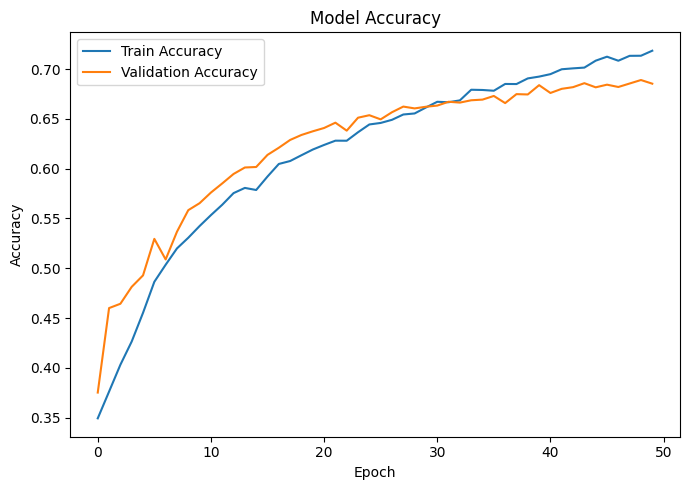

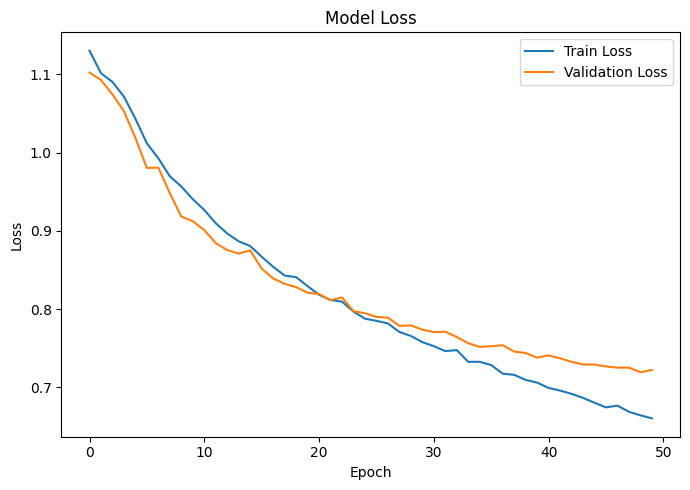

In [13]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(7, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig("model_accuracy_biLSTM.png", dpi=300, bbox_inches='tight')
plt.show()

# Loss plot
plt.figure(figsize=(7, 5))   # new figure
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig("model_loss_biLSTM.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Get predicted probabilities
y_val_probs = model_bilstm.predict(X_val_pad)

# Convert to predicted class labels (0, 1, 2)
y_val_pred = np.argmax(y_val_probs, axis=1)

# Convert to numpy arrays
y_val_true = np.array(y_val)

188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step


In [15]:
# Find misclassified indices
wrong_indices = np.where(y_val_pred != y_val_true)[0]
print(f"Number of misclassified samples: {len(wrong_indices)}")

for idx in wrong_indices[:10]:  # find 10 misclassification
    print(f"\n Review: {X_val.iloc[idx]}")
    print(f"True label: {y_val_true[idx]}")
    print(f"Predicted:  {y_val_pred[idx]}")

Number of misclassified samples: 1866

 Review: i have read that john ringo basically wrote the books in this series over the course of a few months of frantic writing . i have not read the others , but this was a gritty description of commando style spy antics combined with almost bdsm sexual scenes . the military scenes and descriptions are solid . however , they could not carry the story and the overall plot just felt a bit thin . the sexual scenes felt almost forced at time and did not expand much upon the plot . i could see a male reader wishing he was the main character with his almost mystical ability to pleasure a woman and win her adoration , but in a way the scenes detracted from the characters and their impact . perhaps i should have read books 1 and 2 first so i could get more into the story , but i was able to figure out the basic personalities of most of hte characters , even if i did not know how they became friends and allies . this is definitely a book that will only b

In [16]:
from sklearn.metrics import classification_report
# Get predicted class indices from softmax probabilities
y_val_probs = model_bilstm.predict(X_val_pad)
y_val_pred = np.argmax(y_val_probs, axis=1)

# Evaluate against true labels
print(classification_report(y_val, y_val_pred, zero_division=0))

188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      2000
           1       0.58      0.60      0.59      2000
           2       0.72      0.79      0.76      2000

    accuracy                           0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000



94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1000
           1       0.57      0.59      0.58      1000
           2       0.73      0.80      0.77      1000

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000



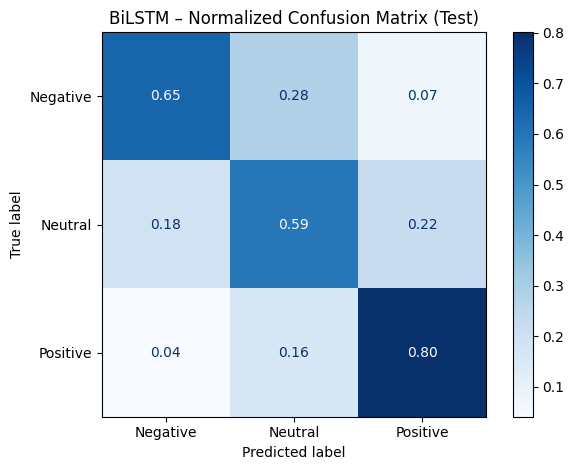

In [17]:
# Test-set predictions
y_test_probs = model_bilstm.predict(X_test_pad)
y_test_pred  = np.argmax(y_test_probs, axis=1)

# Evaluate against true labels
print(classification_report(y_test, y_test_pred, zero_division=0))

# Report + confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_norm = confusion_matrix(y_test, y_test_pred, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Negative','Neutral','Positive'])
disp.plot(values_format='.2f', cmap='Blues')
plt.title('BiLSTM – Normalized Confusion Matrix (Test)')
plt.tight_layout()
plt.savefig('confusion_matrix_BiLSTM.png', dpi=300, bbox_inches='tight')
plt.show()
